In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy import stats
from scipy.stats import pearsonr
from statistics import mean
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm

# plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = "Arial"

### 定义函数

In [53]:
def calculate_U95(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return {
    #     "R": R,
    #     "MBE": MBE,
    #     "%MBE": MBE_percent,
    #     "RMSE": RMSE,
    #     "%RMSE": RMSE_percent,
    #     "U95": U95
    # }

    return U95
    # return RMSE_percent**2

# 示例使用
y_true = [3, 5, 2.5, 7, 4.5]
# y_pred = [6, 7, 3, 8, 5]
y_pred = [5, 5, 2.5, 7, 4.5]
# 转为df
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

metrics = calculate_U95(y_true, y_pred)
# print(metrics['R'])
def calculate_error(observation, model):
    valid_mask = ~np.isnan(observation) & ~np.isnan(model)
    valid_obs = observation[valid_mask]
    valid_mod = model[valid_mask]

    metrics = calculate_U95(valid_obs, valid_mod)

    return metrics
calculate_error(df['y_true'], df['y_pred'])

365.2968036529681

### 将数据按日数据、月均数据、年均数据分组

In [54]:
# 读取数据库
database = pd.read_feather(r'D:\PhD\data\station_feather\station_data_all_v3.feather').rename(columns={'daily_radiation':'Observation'})
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

# 逐日数据
database_ISCCP_d  = database[~database['ISCCP-ITP'].isna()][['date', 'Observation','ISCCP-ITP']].rename(columns={'ISCCP-ITP':'Model'}).reset_index(drop=True)
database_GLASS_d  = database[~database['GLASS'].isna()][['date', 'Observation','GLASS']].rename(columns={'GLASS':'Model'}).reset_index(drop=True)
database_ERA5_d  = database[~database['ERA5'].isna()][['date', 'Observation','ERA5']].rename(columns={'ERA5':'Model'}).reset_index(drop=True)
database_MERRA2_d = database[['date', 'Observation','MERRA2']].rename(columns={'MERRA2':'Model'}).reset_index(drop=True)
database_SSP245_d = database[~database['SSP245'].isna()][['date', 'Observation','SSP245']].rename(columns={'SSP245':'Model'}).reset_index(drop=True)
database_SSP585_d = database[~database['SSP585'].isna()][['date', 'Observation','SSP585']].rename(columns={'SSP585':'Model'}).reset_index(drop=True)
# del database

# 月平均数据
def calculate_monthly_mean(dataframe):
    dataframe_tmp = dataframe.copy()
    # 提取年份和月份
    dataframe_tmp['year'] = dataframe_tmp['date'].apply(lambda x: x.year)
    dataframe_tmp['month'] = dataframe_tmp['date'].apply(lambda x: x.month)
    # 移除日期列
    dataframe_tmp.drop(columns=['date'], inplace=True)
    # 计算每个月的平均值
    monthly_mean = dataframe_tmp.groupby(['year', 'month']).mean().reset_index()
    return monthly_mean

    # """计算稳健的月平均，处理缺失值和日期边界"""
    # df = dataframe.copy()
    # # 确保日期为datetime类型并设为索引
    # df['date'] = pd.to_datetime(df['date'])
    # df.set_index('date', inplace=True)
    # # 按月重采样，要求至少25天有效数据
    # monthly = df.resample('MS').apply(lambda x: x.mean() if len(x) >= 25 else None)
    # # 添加年月列
    # monthly['year'] = monthly.index.year
    # monthly['month'] = monthly.index.month
    # return monthly.reset_index()

database_ISCCP_m = calculate_monthly_mean(database_ISCCP_d)
database_GLASS_m = calculate_monthly_mean(database_GLASS_d)
database_ERA5_m = calculate_monthly_mean(database_ERA5_d)
database_MERRA2_m = calculate_monthly_mean(database_MERRA2_d)
database_SSP245_m = calculate_monthly_mean(database_SSP245_d)
database_SSP585_m = calculate_monthly_mean(database_SSP585_d)

# 年平均数据
def calculate_annual_mean(dataframe):
    dataframe_tmp = dataframe.copy()
    # 提取年份
    dataframe_tmp['year'] = dataframe_tmp['date'].apply(lambda x: x.year)
    # 移除日期列
    dataframe_tmp.drop(columns=['date'], inplace=True)
    # 计算每个月的平均值
    yearly_mean = dataframe_tmp.groupby('year').mean().reset_index()
    return yearly_mean

    # df = dataframe.copy()
    # df['date'] = pd.to_datetime((df['date']))
    # df.set_index('date', inplace=True)
    # yearly = df.resample('AS').apply(lambda x: x.mean() if len(x) >= 300 else None)
    # yearly['year'] = yearly.index.year
    # return yearly.reset_index()

database_ISCCP_y = calculate_annual_mean(database_ISCCP_d)
database_GLASS_y = calculate_annual_mean(database_GLASS_d)
database_ERA5_y = calculate_annual_mean(database_ERA5_d)
database_MERRA2_y = calculate_annual_mean(database_MERRA2_d)
database_SSP245_y = calculate_annual_mean(database_SSP245_d)
database_SSP585_y = calculate_annual_mean(database_SSP585_d)

### 计算各时间尺度下U95

In [55]:
models_d = [database_ISCCP_d, database_GLASS_d, database_ERA5_d, database_MERRA2_d, database_SSP245_d, database_SSP585_d]
models_m = [database_ISCCP_m, database_GLASS_m, database_ERA5_m, database_MERRA2_m, database_SSP245_m, database_SSP585_m]
models_y = [database_ISCCP_y, database_GLASS_y, database_ERA5_y, database_MERRA2_y, database_SSP245_y, database_SSP585_y]

# 计算评价指标
# 按尺度分组
U95_list_d = []
U95_list_m = []
U95_list_y = []
for model in models_d:
    U95 = calculate_error(model['Observation'], model['Model'])
    U95_list_d.append(U95)
for model in models_m:
    U95 = calculate_error(model['Observation'], model['Model'])
    U95_list_m.append(U95)
for model in models_y:
    U95 = calculate_error(model['Observation'], model['Model'])
    U95_list_y.append(U95)
# 按模型分组
U95_ISCCP = []
U95_GLASS = []
U95_ERA5 = []
U95_MERRA2 = []
U95_SSP245 = []
U95_SSP585 = []
# 使用列表推导式和zip函数优化代码
new_lists = [U95_ISCCP, U95_GLASS, U95_ERA5, U95_MERRA2, U95_SSP245, U95_SSP585]
for lst, d, m, y in zip(new_lists, U95_list_d, U95_list_m, U95_list_y):
    lst.extend([d, m, y])

In [25]:
temp = pd.DataFrame(new_lists)

### 绘制05各时间尺度下U95条形图

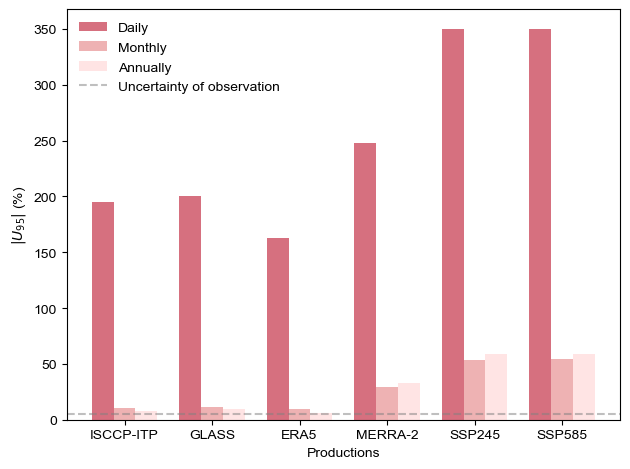

In [56]:
# 设置条形图的宽度和位置
bar_width = 0.25
index = np.arange(len(models_name))


# 绘制条形图
daily_bars = plt.bar(index, U95_list_d, bar_width, label='Daily', color="#d6707f")
monthly_bars = plt.bar(index + bar_width, U95_list_m, bar_width, label='Monthly', color="#eeb2b3")
annually_bars = plt.bar(index + 2 * bar_width, U95_list_y, bar_width, label='Annually', color="#ffe4e4")
# 添加5%水平线
uncertainty_line = plt.axhline(y=5, color='grey', alpha=.5, linestyle='--', label='Uncertainty of observation')

# 添加图例、标题和标签
plt.xlabel('Productions')
plt.ylabel(r'$|U_{95}|$ (%)')
plt.xticks(index + bar_width, models_name)
# 调整图例顺序
plt.legend(handles=[daily_bars, monthly_bars, annually_bars, uncertainty_line],frameon=False)

# 显示图形
plt.tight_layout()
plt.show()